In [1]:
#Homework 5
# S Mackie ASTR 400B

# importing modules
import numpy as np
import astropy.units as u
from astropy.constants import G

# getting previously written functions
from ReadFile import Read
from CenterOfMass import CenterOfMass
from GalaxyMass import ComponentMass

# import plotting modules (from Lab 4)
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# Making the MassProfile class 
class MassProfile:

    # This will construct the filename read in the file, and store all mass and position    
    def __init__(self, galaxy, snap):
        # Inputs:
        #    galaxy = string with galaxy name MW, M31 or M33
        #    snap = snapshot number (ex. 0, 14, 38, etc)
        
        # Making the filename
        # Adds extra 0's to start of the inputted snap number
        ilbl = '000' + str(snap)
        # Gets rid of everything but the last 3 digits
        ilbl = ilbl[-3:]
        # Constructs the filename (ex. MW_000.txt) and saves it to a global property
        # The "../../" is for my directory specifically- I have the snapshots saved two folders up
        self.filename = "../../" + "%s_"%(galaxy) + ilbl + '.txt'
        
        # Read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename)
        
        # Storing the mass, the position, and the galaxy name as 
        # global properties
        self.m = self.data['m']
        self.x = self.data['x'] * u.kpc
        self.y = self.data['y'] * u.kpc
        self.z = self.data['z'] * u.kpc
        self.gname = galaxy
        
    # This function will calculate the mass enclosed w/in a given radius from the COM of 
    # the chosen galaxy and particle type
    def MassEnclosed(self, parttype, r):
        # Inputs:
        #    self = global properties
        #    parttype = particle type (1 = halo, 2 = disk, 3 = bulge)
        #    r = incremented radii (array) from the COM of the target galaxy (MW, M31, or M33) [kpc]
        # Returns:
        #    An array containing the mass enclosed (of a single particle type) w/in each radius [Msun]
        
        # Makes a CenterOfMass object
        COM = CenterOfMass(self.filename, parttype)
        # Calling for the (vector) position of the center of mass [in kpc]
        COMP = COM.COM_P(0.1)
        # Calculates the magnitude of the COM position
        COMPmag = np.sqrt(COMP[0]**2 + COMP[1]**2 + COMP[2]**2)
        
        # calculates how far away each particle is from the galaxy's COM
        xMag = self.x - COMP[0]
        yMag = self.y - COMP[1]
        zMag = self.z - COMP[2]
        rMag = np.sqrt(xMag**2 + yMag**2 + zMag**2)
        
        # This array will store the total mass w/in each radius, where each element 
        # in SumMass corresponds to one radius 
        SumMass = np.zeros(len(r))

        # Loops through for each radius
        for i in range(len(r)):
            
            # This will hold the index of any particle that is within the specified radius 
            # AND is the particle type we want
            WithinR = np.where((rMag <= r[i]) & (self.data['type'] == parttype))
            
            # checking the loop step and the radius at that step
            #print("Iteration: ",i," Radius: ",r[i])
            
            # every particle w/in the radius will have its mass added to the sum
            SumMass[i] = sum(self.m[WithinR])
            
            # checking the elements along the way
            #print("SumMass", SumMass[i])
            
        return SumMass * 1e10 * u.Msun
    
    # This function will calculate the total mass enclosed w/in a given radius from the COM of
    # the chosen galaxy
    def TotalMassEnclosed(self, r):
        # Inputs:
        #    r = incremented radii (array) from the COM of the target galaxy (MW, M31, or M33) [kpc]
        # Returns:
        #    An array containing the total mass enclosed w/in each radius [Msun]
    
        # Initializing the arrays that will hold the masses for each type of particle
        MassHalo = np.zeros(len(r))
        MassDisk = np.zeros(len(r))
        MassBulge = np.zeros(len(r))
   
        # getting the mass arrays for the halo and disk
        MassHalo = self.MassEnclosed(1, r)
        MassDisk = self.MassEnclosed(2, r)
    
        # M33 doesn't have a bulge, so this if statement should leave its MassBulge array as zeros 
        if 'M33' not in self.filename:
            MassBulge = self.MassEnclosed(3, r)
        
        MassTot = MassHalo + MassDisk + MassBulge
    
        return MassTot
        
    # This function will calculate the mass enclosed w/in a given radius using the Hernquist 1990 mass profile:
    # M = Mhalo * r**2 / (a + r)**2
    # This function was taken from Lab3
    # In order to get the total halo mass for any particular galaxy, I think I need to use ComponentMass,
    #    but I'm not sure how to do that outside of this cell since ComponentMass needs the file name,
    #    which is put together in this class
    # Also I'm not sure how to use the scale radius without hard coding it in
    # For now I'll just leave the copied function as is for the Milky Way
    def HernquistMass(self, r, a, MHaloTot):
        # Inputs:
        #    r is the distance from the center of the galaxy [kpc]
        #    a is the scale radius [kpc]
        #    MHaloTot is the total dark matter halo mass [1e10 Msun]
        # Return:
        #    The total dark matter mass enclosed within radius r [Msun]
        
        r = r / u.kpc
    
        return np.round(MHaloTot * r**2 / (a + r)**2,2) * 1e10
    
    # This function will calculate the circular velocity at each radius for one particle type:
    # Vcirc = sqrt(G M / r)
    def CircularVelocity(self, parttype, r):
        # Inputs:
        #    parttype = particle type (1 = halo, 2 = disk, 3 = bulge)
        #    r = distance from the center of the galaxy [kpc]
        # Returns: 
        #    an array of circular speeds [km/s]
        
        # Putting G in the units we need to get the circ. vel. into km/s
        # making it a global property so I don't have to do this again
        self.G = G.to(u.kpc*u.km**2/u.s**2/u.Msun)
                
        # Getting the enclosed mass at each radius
        Menc = self.MassEnclosed(parttype,r)
        
        # Calculating Vcirc
        Vcirc = np.sqrt(self.G * Menc / r )
        
        return np.around(Vcirc,2)
    
    # This function will calculate the total circular velocity at each radius:
    # Vcirc = sqrt(G M / r)
    def CircularVelocityTotal(self, r):
        # Input:
        #    r = array of distances from the center of the galaxy [kpc]
        # Returns: 
        #    an array of circular speeds [km/s]
        
        # Getting the total enclosed mass at each radius
        MencTot = self.TotalMassEnclosed(r)
        
        # Calculating Vcirc
        Vcirc = np.sqrt(self.G * MencTot / r )
        
        return np.around(Vcirc,2)
    
    # This function will calculate the circular velocity using the Hernquist mass profile
    def HernquistVCirc(self, r, a, MHaloTot):
        # Inputs:
        #    r is the distance from the center of the galaxy [kpc]
        #    a is the scale radius [kpc]
        #    MHaloTot is the total dark matter halo mass [1e10 Msun]
        # Return:
        #    The circular speed [km/s]
        
        # Getting the enclosed mass at each radius
        Menc = self.HernquistMass(r, a, MHaloTot)
        
        # Need this so it won't yell at me about units
        # astropy units on HernquistG = [kpc]
        HernquistG = self.G * u.Msun * u.s**2 / u.km**2 
        
        # Calculating Vcirc
        Vcirc = np.sqrt(HernquistG * Menc / r )
        
        return np.around(Vcirc,2)

## Setup for plotting

In [3]:
# Coords. have units so r[i] needs units too
# From 0.1 kpc to 30.1 kpc stepping by .025 kpc
r = np.arange(0.1, 30.1, 0.25) * u.kpc

# Initializing the MassProfile class
MW = MassProfile("MW", 0) 
M31 = MassProfile("M31", 0) 
M33 = MassProfile("M33", 0) 

# Getting the total halo mass for all the galaxies [unitless but scaled by 1e10 instead of 1e12]
MWHaloTot = ComponentMass('../../MW_000.txt', 1) * 100 / u.Msun
M31HaloTot = ComponentMass('../../M31_000.txt', 1) * 100 / u.Msun
M33HaloTot = ComponentMass('../../M33_000.txt', 1) * 100 / u.Msun


# Milky Way Mass Profile

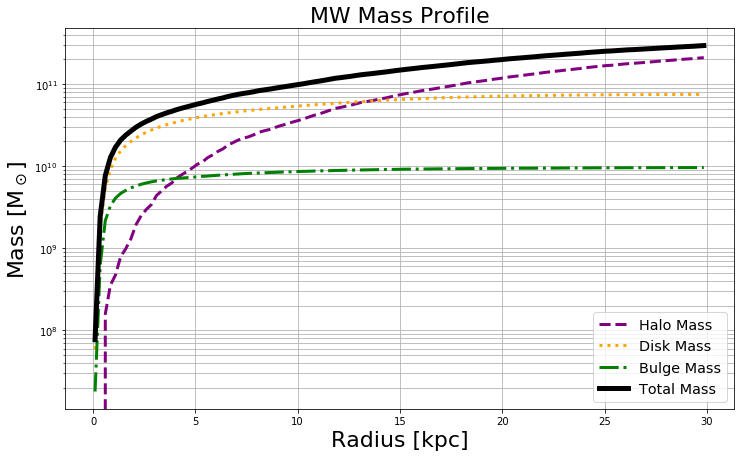

In [4]:
# Getting the masses of each component and in total
MWMassHalo = MW.MassEnclosed(1,r)
MWMassDisk = MW.MassEnclosed(2,r)
MWMassBulge = MW.MassEnclosed(3,r)
MWMassTot = MW.TotalMassEnclosed(r)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
plt.plot(r, MWMassHalo, color='purple', linestyle = '--', linewidth=3, label='Halo Mass')
plt.plot(r, MWMassDisk, color='orange', linestyle = ':', linewidth=3, label='Disk Mass')
plt.plot(r, MWMassBulge, color='green', linestyle = '-.', linewidth=3, label='Bulge Mass')
plt.plot(r, MWMassTot, color='black', linewidth=5, label='Total Mass')

# Adding a plot title
plt.title('MW Mass Profile', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

## MW Hernquist Mass Profile 

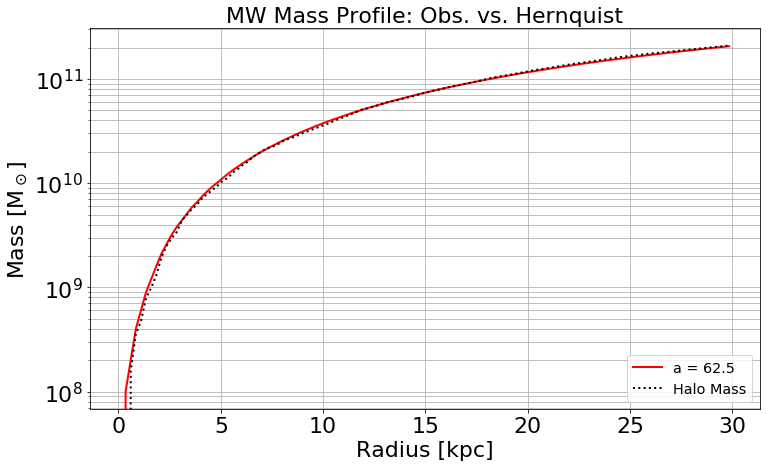

In [5]:
# Initializing the hernquist arrays
MWHernquist60 = np.zeros(len(r))
MWHernquist55 = np.zeros(len(r))
MWHernquist65 = np.zeros(len(r))
MWHernquist62pt5 = np.zeros(len(r))

# Getting the Hernquist mass profile for several values of the scale radius a
for i in range(len(r)):
    MWHernquist60[i] = MW.HernquistMass(r[i], 60, MWHaloTot) # a = 60 is from Lab 3
    MWHernquist55[i] = MW.HernquistMass(r[i], 55, MWHaloTot) # graph too high
    MWHernquist65[i] = MW.HernquistMass(r[i], 65, MWHaloTot) # graph too low
    MWHernquist62pt5[i] = MW.HernquistMass(r[i], 62.5, MWHaloTot) # just right


# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
#plt.plot(r, MWHernquist60, color='purple', linewidth=2, label='a = 60')
#plt.plot(r, MWHernquist55, color='blue', linewidth=2, label='a = 55')
#plt.plot(r, MWHernquist65, color='green', linewidth=2, label='a = 65')
plt.plot(r, MWHernquist62pt5, color='red', linewidth=2, label='a = 62.5')
plt.plot(r, MWMassHalo, color='black', linestyle=':', linewidth=2, label='Halo Mass')

# Adding a plot title
plt.title('MW Mass Profile: Obs. vs. Hernquist', fontsize=22, loc='center')

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

I plotted all of the MWHernquist## but it got cluttered, so I graphed them one at a time, this particular graph 
shows that a scale length of 62.5 kpc seems to fit the halo mass profile of the Milky Way very well

# Andromeda Mass Profile

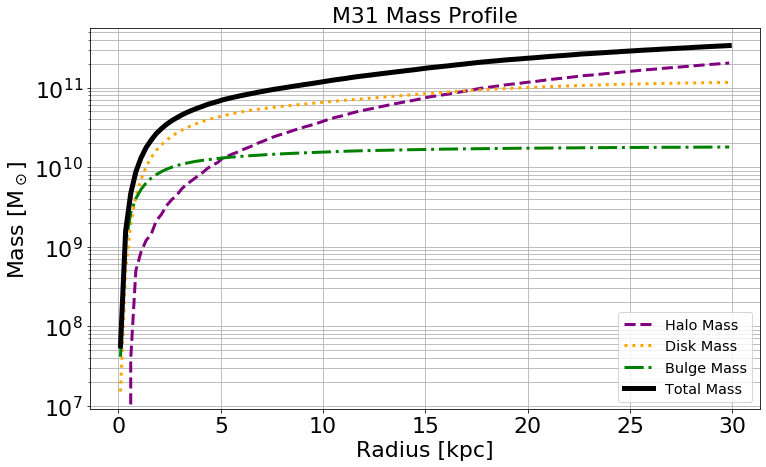

In [6]:
# Getting the masses of each component and in total
M31MassHalo = M31.MassEnclosed(1,r)
M31MassDisk = M31.MassEnclosed(2,r)
M31MassBulge = M31.MassEnclosed(3,r)
M31MassTot = M31.TotalMassEnclosed(r)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
plt.plot(r, M31MassHalo, color='purple', linestyle = '--', linewidth=3, label='Halo Mass')
plt.plot(r, M31MassDisk, color='orange', linestyle = ':', linewidth=3, label='Disk Mass')
plt.plot(r, M31MassBulge, color='green', linestyle = '-.', linewidth=3, label='Bulge Mass')
plt.plot(r, M31MassTot, color='black', linewidth=5, label='Total Mass')

# Adding a plot title
plt.title('M31 Mass Profile', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

## M31 Hernquist Mass Profile 

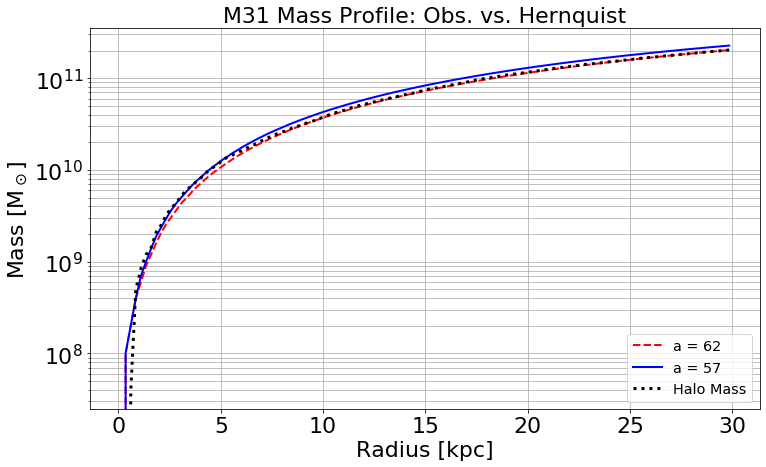

In [7]:
# Initializing the hernquist arrays
M31Hernquist60 = np.zeros(len(r))
M31Hernquist65 = np.zeros(len(r))
M31Hernquist55 = np.zeros(len(r))
M31Hernquist62 = np.zeros(len(r))
M31Hernquist57 = np.zeros(len(r))

# Getting the Hernquist mass profile for several values of the scale radius a
for i in range(len(r)):
    M31Hernquist60[i] = M31.HernquistMass(r[i], 60, M31HaloTot) # a = 60 is from Lab 3, but for the MW
    M31Hernquist65[i] = M31.HernquistMass(r[i], 65, M31HaloTot) # graph too low
    M31Hernquist55[i] = M31.HernquistMass(r[i], 55, M31HaloTot) # graph too high
    M31Hernquist62[i] = M31.HernquistMass(r[i], 62, M31HaloTot)
    M31Hernquist57[i] = M31.HernquistMass(r[i], 57, M31HaloTot)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
#plt.plot(r, M31Hernquist60, color='purple', linewidth=2, label='a = 60')
#plt.plot(r, M31Hernquist65, color='blue', linewidth=2, label='a = 65')
#plt.plot(r, M31Hernquist55, color='green', linewidth=2, label='a = 55')
plt.plot(r, M31Hernquist62, color='red', linestyle ='--', linewidth=2, label='a = 62')
plt.plot(r, M31Hernquist57, color='blue', linewidth=2, label='a = 57')
plt.plot(r, M31MassHalo, color='black', linestyle=':', linewidth=3, label='Halo Mass')

# Adding a plot title
plt.title('M31 Mass Profile: Obs. vs. Hernquist', fontsize=22, loc='center')

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

For Andromeda, a scale radius of 57 seems to fit up to 5 kpc, and past 5 kpc a scale radius of 62 fits better.

# Triangulum Mass Profile

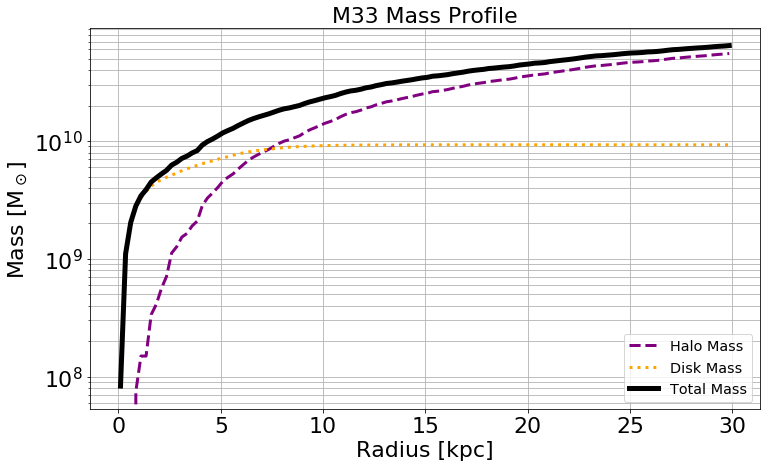

In [8]:
# Getting the masses of each component and in total
M33MassHalo = M33.MassEnclosed(1,r)
M33MassDisk = M33.MassEnclosed(2,r)
M33MassTot = M33.TotalMassEnclosed(r)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
plt.plot(r, M33MassHalo, color='purple', linestyle = '--', linewidth=3, label='Halo Mass')
plt.plot(r, M33MassDisk, color='orange', linestyle = ':', linewidth=3, label='Disk Mass')
plt.plot(r, M33MassTot, color='black', linewidth=5, label='Total Mass')

# Adding a plot title
plt.title('M33 Mass Profile', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

## M33 Hernquist Mass Profile 

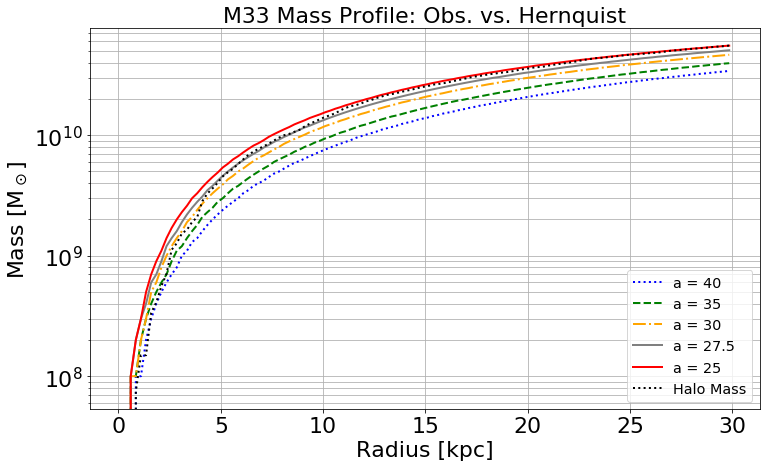

In [9]:
# Initializing the hernquist arrays
M33Hernquist60 = np.zeros(len(r))
M33Hernquist55 = np.zeros(len(r))
M33Hernquist40 = np.zeros(len(r))
M33Hernquist35 = np.zeros(len(r))
M33Hernquist30 = np.zeros(len(r))
M33Hernquist27pt5 = np.zeros(len(r))
M33Hernquist25 = np.zeros(len(r))

# Getting the Hernquist mass profile for several values of the scale radius a
for i in range(len(r)):
    M33Hernquist60[i] = M33.HernquistMass(r[i], 60, M33HaloTot) # a = 60 is from Lab 3, but for the MW, way too low
    M33Hernquist55[i] = M33.HernquistMass(r[i], 55, M33HaloTot) # graph too low
    M33Hernquist40[i] = M33.HernquistMass(r[i], 40, M33HaloTot)
    M33Hernquist35[i] = M33.HernquistMass(r[i], 35, M33HaloTot)
    M33Hernquist30[i] = M33.HernquistMass(r[i], 30, M33HaloTot)
    M33Hernquist27pt5[i] = M33.HernquistMass(r[i], 27.5, M33HaloTot)
    M33Hernquist25[i] = M33.HernquistMass(r[i], 25, M33HaloTot)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Making the y axis scale by log10 (not sure how to get semilogy to work atm)
ax.set_yscale('log')

# Plotting the data
#plt.plot(r, M33Hernquist60, color='purple', linewidth=2, label='a = 60')
#plt.plot(r, M33Hernquist55, color='blue', linewidth=2, label='a = 55')
plt.plot(r, M33Hernquist40, color='blue', linestyle = ':', linewidth=2, label='a = 40')
plt.plot(r, M33Hernquist35, color='green', linestyle = '--', linewidth=2, label='a = 35')
plt.plot(r, M33Hernquist30, color='orange', linestyle = '-.', linewidth=2, label='a = 30')
plt.plot(r, M33Hernquist27pt5, color='grey', linewidth=2, label='a = 27.5')
plt.plot(r, M33Hernquist25, color='red', linewidth=2, label='a = 25')
plt.plot(r, M33MassHalo, color='black', linestyle=':', linewidth=2, label='Halo Mass')

# Adding a plot title
plt.title('M33 Mass Profile: Obs. vs. Hernquist', fontsize=22, loc='center')

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('Mass [M$_\odot$]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

No single value of the scale radius seems to fit M33's halo mass profile.

a = 40 kpc fits radii < ~2.5 kpc and a = 25 fits radii > ~12 kpc

a = 27.5 fits between ~5 to 10 kpc

# Milky Way Rotation Curve

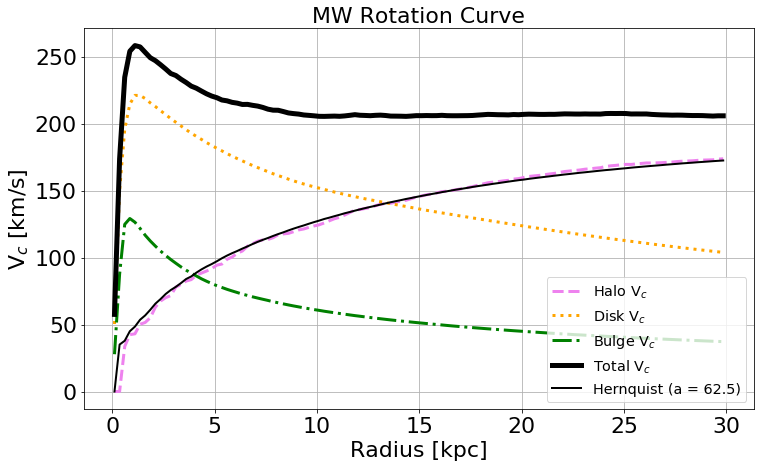

In [10]:
# Initializing the Hernquist Vcirc array
MWHernquistV62pt5 = np.zeros(len(r))


# Getting the velocities of each component and in total
MWVcHalo = MW.CircularVelocity(1,r)
MWVcDisk = MW.CircularVelocity(2,r)
MWVcBulge = MW.CircularVelocity(3,r)
MWVcTot = MW.CircularVelocityTotal(r)

# Filling the Hernquist Vcirc array (after the others b/c self.G is defined in CircularVelocity)
for i in range(len(r)):
    MWHernquistV62pt5[i] = MW.HernquistVCirc(r[i], 62.5, MWHaloTot)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Plotting the data
plt.plot(r, MWVcHalo, color='violet', linestyle = '--', linewidth=3, label='Halo V$_c$')
plt.plot(r, MWVcDisk, color='orange', linestyle = ':', linewidth=3, label='Disk V$_c$')
plt.plot(r, MWVcBulge, color='green', linestyle = '-.', linewidth=3, label='Bulge V$_c$')
plt.plot(r, MWVcTot, color='black', linewidth=5, label='Total V$_c$')
plt.plot(r, MWHernquistV62pt5, color='black', linestyle ='-', linewidth=2, label='Hernquist (a = 62.5)')

# Adding a plot title
plt.title('MW Rotation Curve', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('V$_c$ [km/s]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

# Andromeda Rotation Curve

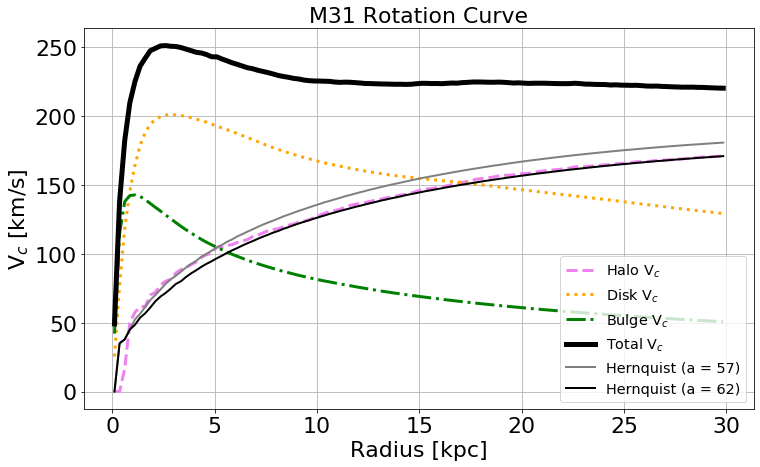

In [11]:
# Initializing the Hernquist Vcirc arrays
M31HernquistV62 = np.zeros(len(r))
M31HernquistV57 = np.zeros(len(r))
    
# Getting the masses of each component and in total
M31VcHalo = M31.CircularVelocity(1,r)
M31VcDisk = M31.CircularVelocity(2,r)
M31VcBulge = M31.CircularVelocity(3,r)
M31VcTot = M31.CircularVelocityTotal(r)

# Filling the Hernquist Vcirc arrays 
for i in range(len(r)):
    M31HernquistV62[i] = M31.HernquistVCirc(r[i], 62, M31HaloTot)
    M31HernquistV57[i] = M31.HernquistVCirc(r[i], 57, M31HaloTot)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Plotting the data
plt.plot(r, M31VcHalo, color='violet', linestyle = '--', linewidth=3, label='Halo V$_c$')
plt.plot(r, M31VcDisk, color='orange', linestyle = ':', linewidth=3, label='Disk V$_c$')
plt.plot(r, M31VcBulge, color='green', linestyle = '-.', linewidth=3, label='Bulge V$_c$')
plt.plot(r, M31VcTot, color='black', linewidth=5, label='Total V$_c$')
plt.plot(r, M31HernquistV57, color='gray', linestyle ='-', linewidth=2, label='Hernquist (a = 57)')
plt.plot(r, M31HernquistV62, color='black', linestyle ='-', linewidth=2, label='Hernquist (a = 62)')

# Adding a plot title
plt.title('M31 Rotation Curve', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('V$_c$ [km/s]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

Again, a = 57 kpc kind of fits at near distances and a = 62 kpc matches at farther distances

# Triangulum Rotation Curve

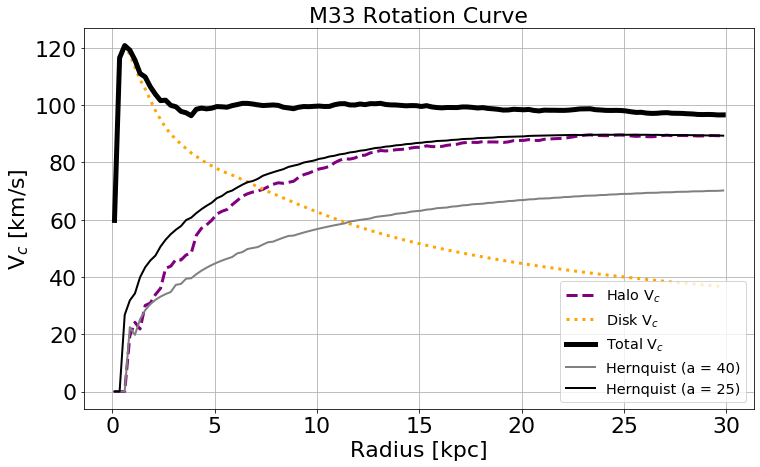

In [12]:
# Initializing the Hernquist Vcirc arrays
M33HernquistV40 = np.zeros(len(r))
M33HernquistV25 = np.zeros(len(r))

# Getting the masses of each component and in total
M33VcHalo = M33.CircularVelocity(1,r)
M33VcDisk = M33.CircularVelocity(2,r)
M33VcTot = M33.CircularVelocityTotal(r)

# Filling the Hernquist Vcirc arrays
for i in range(len(r)):
    M33HernquistV40[i] = M33.HernquistVCirc(r[i], 40, M33HaloTot)
    M33HernquistV25[i] = M33.HernquistVCirc(r[i], 25, M33HaloTot)

# Frankensteined the ploting code from Labs 4 and 5
fig,ax = plt.subplots(figsize=(12,7))

# Plotting the data
plt.plot(r, M33VcHalo, color='purple', linestyle = '--', linewidth=3, label='Halo V$_c$')
plt.plot(r, M33VcDisk, color='orange', linestyle = ':', linewidth=3, label='Disk V$_c$')
plt.plot(r, M33VcTot, color='black', linewidth=5, label='Total V$_c$')
plt.plot(r, M33HernquistV40, color='gray', linestyle ='-', linewidth=2, label='Hernquist (a = 40)')
plt.plot(r, M33HernquistV25, color='black', linestyle ='-', linewidth=2, label='Hernquist (a = 25)')

# Adding a plot title
plt.title('M33 Rotation Curve', fontsize=22, loc='center', pad=None)

# Adding axis labels
plt.xlabel('Radius [kpc]', fontsize=22)
plt.ylabel('V$_c$ [km/s]', fontsize=22)

# Adjusting tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# Displaying a grid
plt.grid(True, which="both")

# Adding a legend with some customizations.
legend = ax.legend(loc='lower right',fontsize='x-large')

# Showing the plot
plt.show()

Again, it looks like the scale radius that fits M33 ranges from a = 25 kpc to a = 40 kpc

## Some comments
The Hernquist profile seems to fit the Milky Way's dark matter distribution, but loosens with Andromeda and falls apart with Triangulum. I'm not entirely sure what to conclude from this, but it's interesting to see that there may be other ways to describe how dark matter is distributed in galaxies aside from our own.